In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [143]:
# Import data

fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_filt = pd.read_csv(r'..\data\processed\filtered_raw_data.csv', index_col=0)
fr_norm = pd.read_csv(r'..\data\processed\run_1_median_linregress_normalized_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_groupings.csv')

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]

diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

In [158]:
obs_used = obs[obs['animal'].isin(animals_used)]

### The normal/impaired/diabetic classification came from, presumably, the oral glucose test (OGTT) 

The OGTT area under curve (AUC) gives the integration of the OGTT blood glucose based on the time points between 0 and 120 minutes 

In [144]:
# pt = phenotypes of animals sampled for LCMS
pt = animal_phenotypes[animal_phenotypes['animal'].isin(animals_used)].sort_values('glucose_tolerance')
pt

,animal,Date of birth,lcms_sampled,glucose_tolerance,10.6g dextrose in 6mL distilled water; total 12.5mL solution,OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min),OGTT (AUC),HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
6,1076,2021-01-23,True,diabetic,138.0,352.5,513.5,585.0,600.0,406.5,2321.25,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
9,1082,2021-01-24,True,diabetic,62.0,258.0,600.0,600.0,571.5,328.5,2224.75,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN
17,1101,2021-02-01,True,diabetic,64.5,216.5,519.5,582.0,587.0,309.0,2015.75,NaN,0.9262,0.838190,0.6216,0.562534,1.490026,murky,Yes definitely,NaN
0,1060,2021-01-23,True,impaired,58.5,178.0,314.5,551.0,589.0,200.0,1761.75,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
2,1062,2021-01-23,True,impaired,56.5,219.0,334.0,462.0,511.0,189.0,1648.75,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
4,1074,2021-01-23,True,impaired,38.5,160.0,308.0,368.0,445.5,99.0,1350.25,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
11,1092,2021-01-31,True,impaired,59.5,206.0,303.5,392.0,401.0,91.5,1377.95,NaN,1.2902,1.312513,0.6312,0.642116,2.044043,clear,Slight,NaN
18,1102,2021-02-01,True,impaired,48.5,216.5,477.5,343.5,538.5,276.0,1738.25,NaN,1.7053,1.405853,0.8780,0.723825,1.942255,murky,Very slight,NaN
10,1091,2021-01-31,True,normal,72.0,172.5,201.5,208.0,195.0,67.5,846.75,NaN,1.4930,1.615801,0.5354,0.579437,2.788569,clear,Slight,NaN
12,1093,2021-01-31,True,normal,50.0,139.5,221.0,268.5,300.5,77.0,993.00,NaN,1.1374,1.203598,0.5462,0.577989,2.082387,clear,Yes,NaN


Text(0, 0.5, 'AUC')

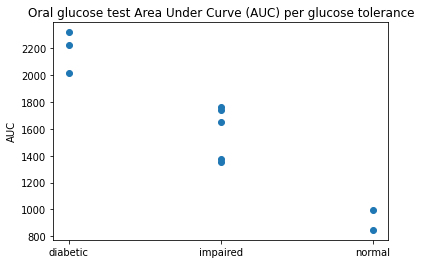

In [145]:
plt.scatter(pt['glucose_tolerance'], pt['OGTT (AUC)'])
plt.title('Oral glucose test Area Under Curve (AUC) per glucose tolerance')
plt.ylabel('AUC')

Text(0.5, 1.0, 'OGTT result by rat date of birth')

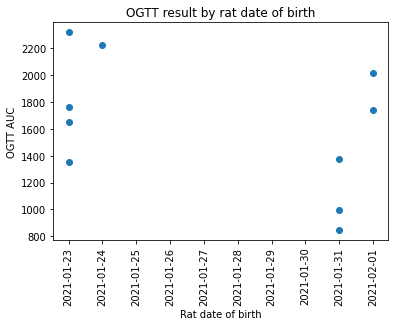

In [146]:
plt.scatter(pt['Date of birth'], pt['OGTT (AUC)'])
plt.xticks(rotation=90)
plt.xlabel('Rat date of birth')
plt.ylabel('OGTT AUC')
plt.title('OGTT result by rat date of birth')# \n(Includes rats not sampled for LC-MS)')

<AxesSubplot:xlabel='datetime'>

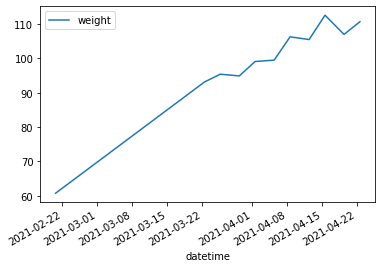

In [147]:
obs_used[(obs_used['weight type'] == 'Weight') & (obs_used['animal'] == 1076)][['datetime', 'weight']].plot('datetime', 'weight')

<AxesSubplot:xlabel='datetime'>

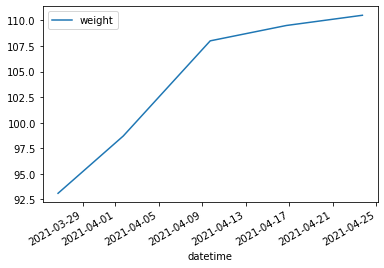

In [148]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['animal'] == 1101)][['datetime', 'weight']].plot('datetime', 'weight')

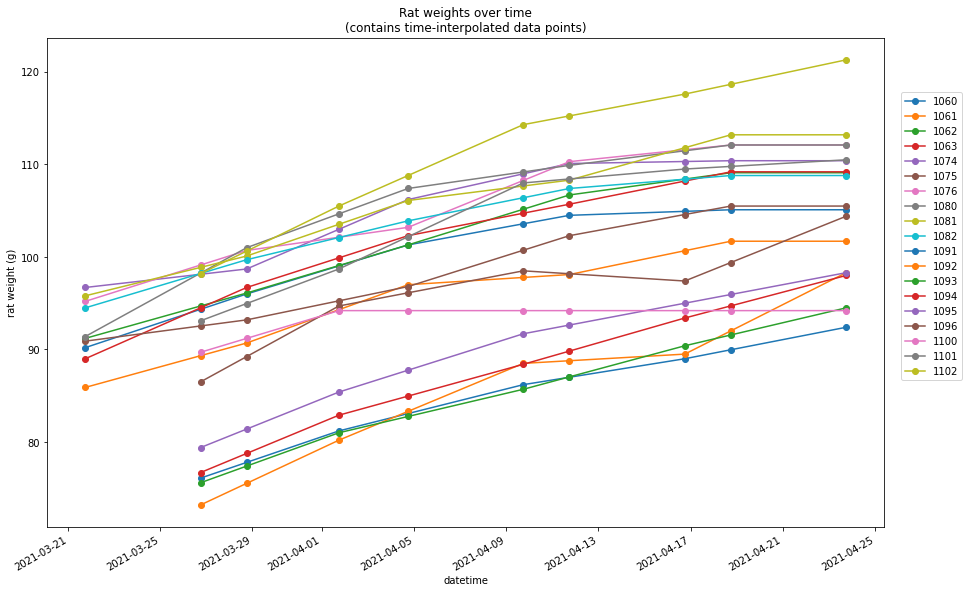

In [151]:
obs_used[(obs_used['weight type'] == 'Weight (pre-fasting)') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'weight', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='weight')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 10)
plt.ylabel('rat weight (g)')
plt.title('Rat weights over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.02, 0.3))

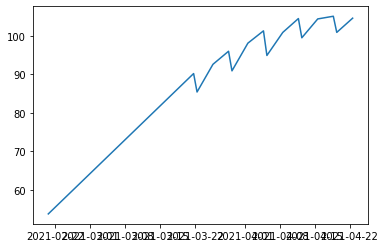

In [58]:
obs_used[obs_used['animal'] == 1060][['datetime', 'weight']]

plt.plot(obs_used[obs_used['animal'] == 1060][['datetime',]], obs_used[obs_used['animal'] == 1060][['weight']])

In [28]:
obs_used['BG type'].unique()

array(['RBG', 'RBG (pre-fasting)', 'FBG', 'Post-OGTT BG'], dtype=object)

In [29]:
obs_used['weight type'].unique()

array(['Weight', 'Weight (pre-fasting)'], dtype=object)

In [122]:
obs_used

,animal,when,BG,weight,weight change %,BG type,weight type,weight change type,weeks old note,note,datetime
0,1060,2/20 3pm,71.0,53.7,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
2,1062,2/20 3pm,78.0,51.3,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
4,1074,2/20 3pm,70.0,55.8,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
6,1076,2/20 3pm,96.0,60.7,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
9,1082,2/20 3pm,90.0,54.1,NaN,RBG,Weight,change,4 weeks old,NaN,2021-02-20 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...
295,1091,4/27 3pm,68.0,89.6,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
296,1092,4/27 3pm,44.0,97.5,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
297,1093,4/27 3pm,65.0,92.3,NaN,Post-OGTT BG,Weight,gain,12 weeks old,NaN,2021-04-27 15:00:00
302,1101,4/27 3pm,NaN,NaN,NaN,Post-OGTT BG,Weight,gain,12 weeks old,Missing data,2021-04-27 15:00:00


In [136]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')

animal,1060,1062,1074,1076,1082,1091,1092,1093,1101,1102
datetime,,,,,,,,,,
2021-03-25 15:00:00,225.0,256.5,232.5,387.666667,272.0,NaN,NaN,NaN,NaN,NaN
2021-03-30 15:00:00,NaN,NaN,NaN,NaN,NaN,108.5,76.0,82.0,459.500000,299.5
2021-04-01 15:00:00,83.0,250.5,203.5,281.000000,339.5,NaN,NaN,NaN,NaN,NaN
2021-04-06 15:00:00,NaN,NaN,NaN,NaN,NaN,86.0,70.5,83.0,342.666667,227.5
2021-04-08 15:00:00,206.0,139.5,205.5,349.000000,330.5,NaN,NaN,NaN,NaN,NaN
2021-04-13 15:00:00,NaN,NaN,NaN,NaN,NaN,71.5,59.0,69.5,352.000000,308.0
2021-04-15 15:00:00,221.0,248.5,225.5,391.500000,413.0,NaN,NaN,NaN,NaN,NaN
2021-04-20 15:00:00,NaN,NaN,NaN,NaN,NaN,78.0,58.0,65.5,505.500000,338.5


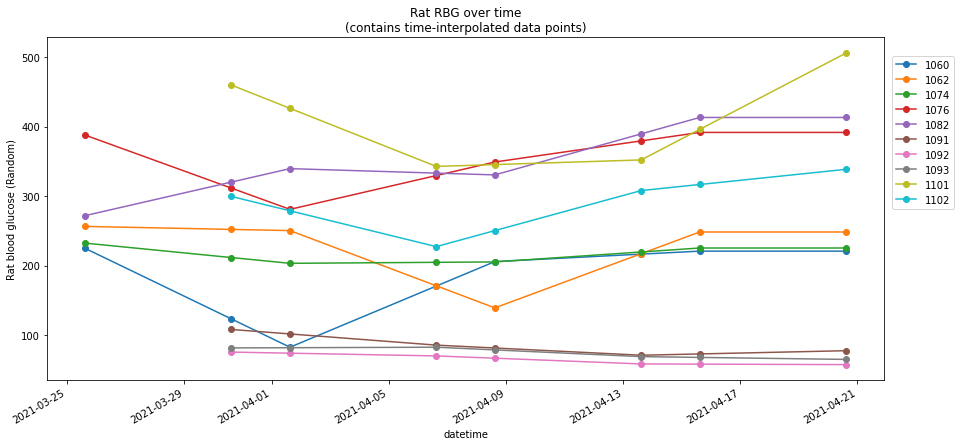

In [140]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .dropna(axis=0, how='all')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose (Random)')
plt.title('Rat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

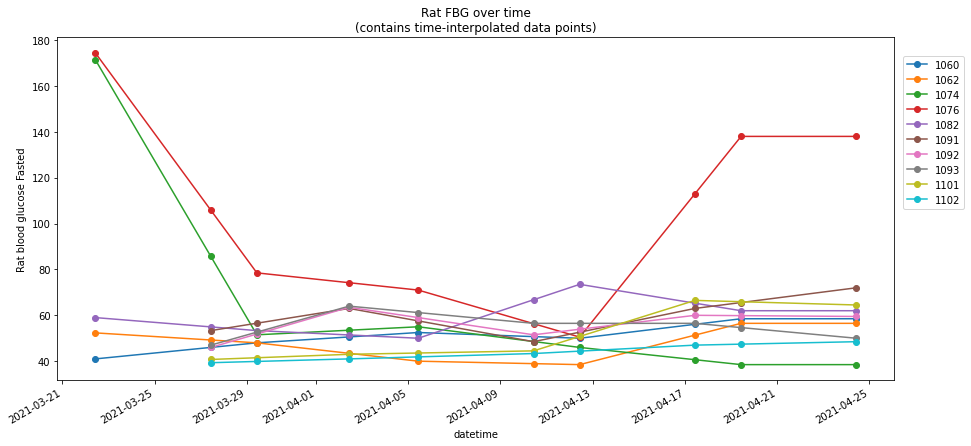

In [160]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot(marker='o')

plt.gcf().set_size_inches(15, 7)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Rat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

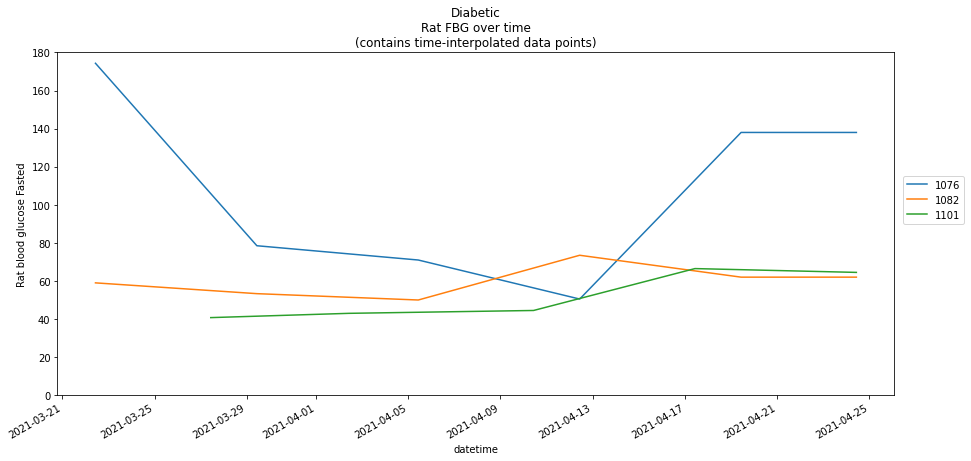

In [167]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

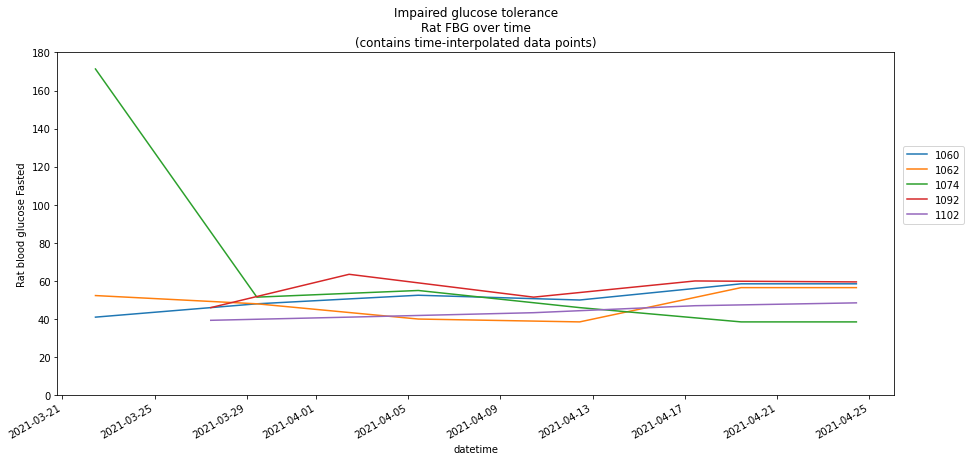

In [168]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

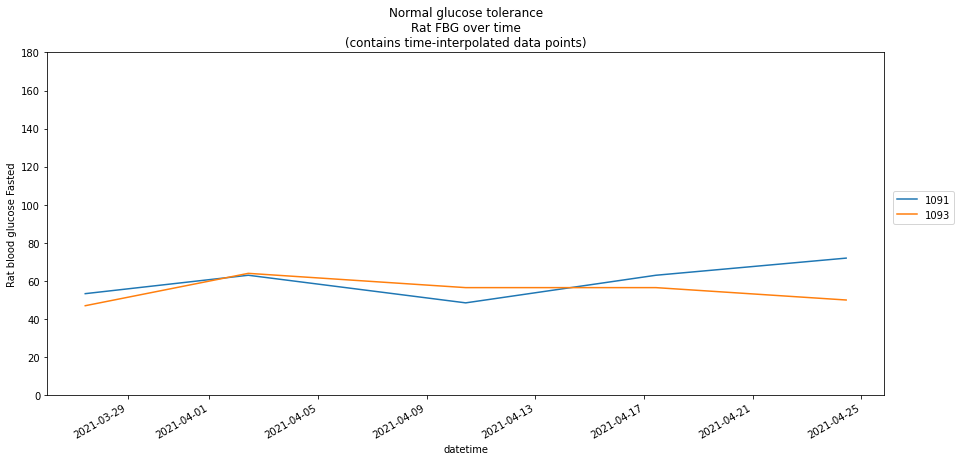

In [169]:
obs_used[(obs_used['BG type'] == 'FBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 180)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat FBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

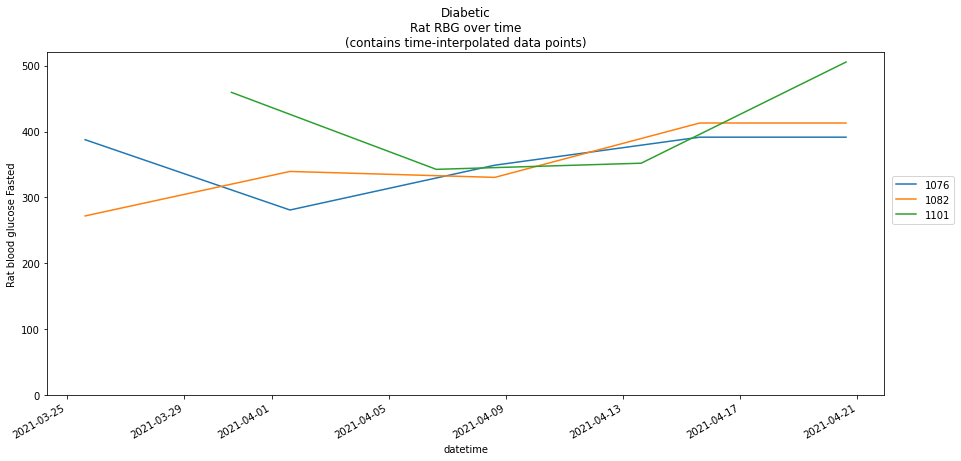

In [183]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(diabetic)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Diabetic\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

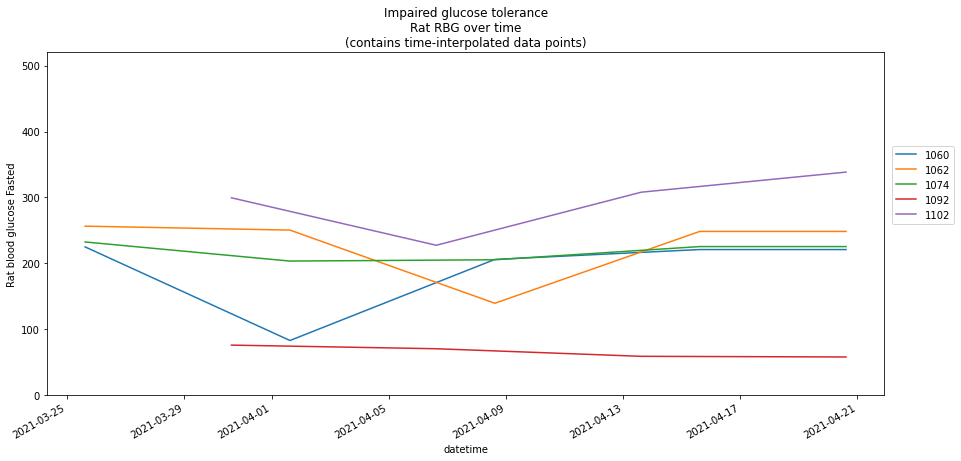

In [184]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(impaired)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Impaired glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))

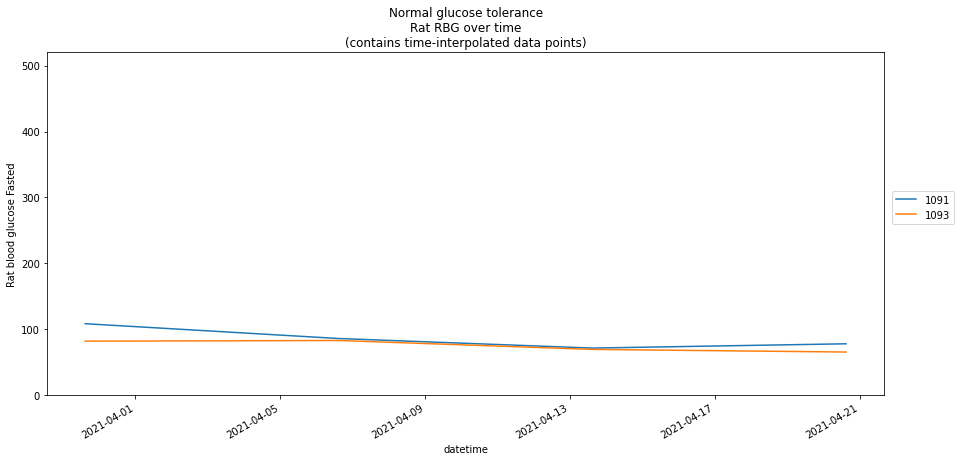

In [185]:
obs_used[(obs_used['BG type'] == 'RBG') & (obs_used['animal'].isin(normal)) & (obs_used['datetime'] > '2021-03-01')]\
    [['animal', 'BG', 'datetime']]\
    .pivot(index='datetime', columns='animal', values='BG')\
    .interpolate(method='time')\
    .plot()

plt.gcf().set_size_inches(15, 7)
plt.ylim(0, 520)
plt.ylabel('Rat blood glucose Fasted')
plt.title('Normal glucose tolerance\nRat RBG over time\n(contains time-interpolated data points)')
plt.legend(loc=(1.01,0.5))